1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [2]:
import numpy as np
import scipy.stats
import scipy
import pandas as pd
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

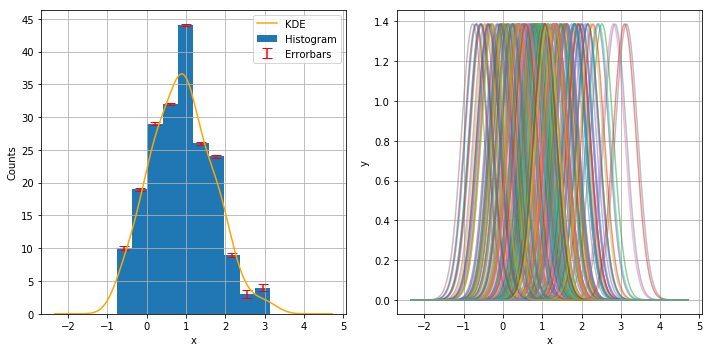

In [18]:
#np.random.seed(1235)

N=200
mu, sigma=np.random.rand(), np.random.rand()
#print(mean)
x=np.random.normal(mu, sigma, N)

#Calculating best binning using Friedmann-Driaconis rule
iqr = np.subtract(*np.percentile(x, [75, 25]))
h = 2 * iqr / (N**(1/3))
nbin = int((x.max() - x.min())/h)

#Histogram
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set_ylabel('Counts')
ax1.set_xlabel('x')
counts, bins, patches=ax1.hist(x,bins=nbin, label='Histogram')
bin_centers = 0.5*(bins[1:] + bins[:-1])
ax1.errorbar(bin_centers, counts, yerr=1/(np.sqrt(counts)),color='red', fmt='none', marker='.', capsize=5, label='Errorbars')


#Gaussians
stdev=1.06*np.std(x)*(x.size**(-1/5))
points=np.linspace(min(x)-(max(x)/2),max(x)+(max(x)/2),N)
gaussian=np.zeros((len(points),len(x)))
for i in np.arange(len(x)):
    gaussian[i,:]=scipy.stats.norm.pdf(points,x[i],stdev)
    ax2.plot(points,gaussian[i,:],alpha = 0.5)
ax2.set_xlabel('x')
ax2.set_ylabel('y')

#Normalizing the KDE
kde=np.sum(gaussian, axis=0)
kde_int=scipy.integrate.trapz(kde, points)
hist_int=scipy.integrate.trapz(counts, bin_centers)
kde=kde*hist_int/kde_int
ax1.plot(points, kde, label='KDE', color='orange')

ax1.grid()
ax2.grid()
ax1.legend()
fig.tight_layout()
plt.show()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

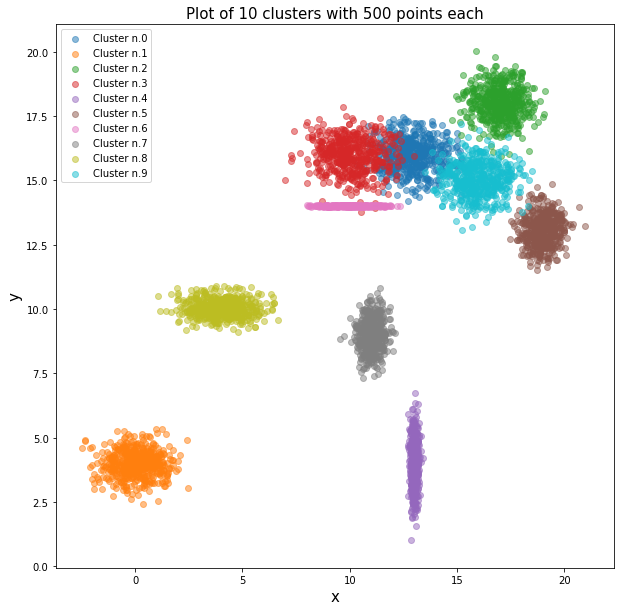

In [16]:
def dataset_gen(n, number_of_data):
    df=pd.DataFrame()
    for i in range(n):
        mean_x=np.random.randint(0,20)
        mean_y=np.random.randint(0,20)
        std_x=np.random.rand()
        std_y=np.random.rand()
        x=np.random.normal(mean_x, std_x, number_of_data)
        y=np.random.normal(mean_y, std_y, number_of_data)
        label=str(i)
        df['x'+label]=x
        df['y'+label]=y
    
    fig=plt.figure(figsize=(10,10))
    for i in range(n):
        string=str(i)
        plt.scatter(x=df['x'+string],y=df['y'+string],marker='o',alpha=0.5, label='Cluster n.'+str(i))  
    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=15)
    plt.title('Plot of '+str(n)+' clusters with '+str(number_of_data)+' points each', fontsize=15)
    plt.legend()
    plt.show() 
    return df

n=10
number_of_data=500
df=dataset_gen(n, number_of_data)

In [ ]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should you the `np.load()` function to load the file as a numpy array and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

C:\Users\chime\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


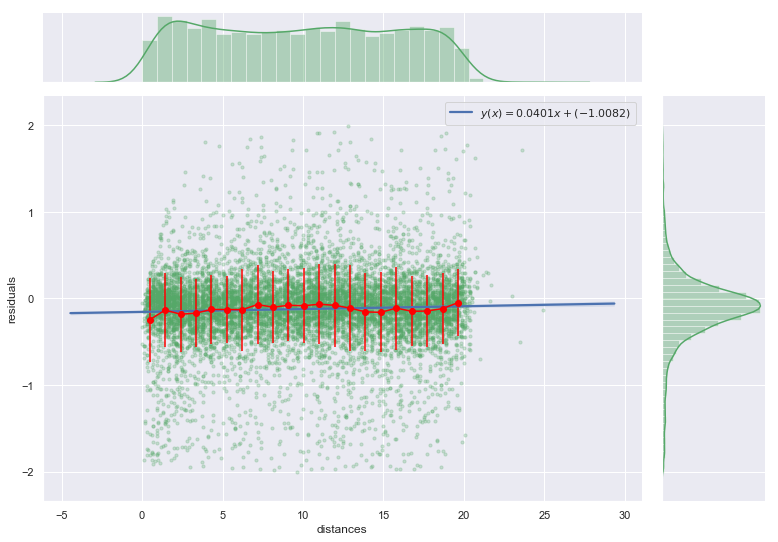

In [79]:
dataraw = pd.DataFrame(np.load('/Users/chime/Documents/LaboratoryOfComputationalPhysics/data/residuals_261.npy').item())

data = dataraw[np.absolute(dataraw['residuals'])<2]

#Regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dataraw['distances'], dataraw['residuals'])

#Seaborn jointplot
sns.set()
graph = sns.jointplot(x = 'distances', y = 'residuals', data = data, kind = 'reg', color='g', 
                      scatter_kws={'alpha':0.25, 's':10}, 
                      line_kws={'label':r"$y(x)={0:.4f}x+({1:.4f})$".format(slope, intercept), 'color':'b'})

#Calculating best binning using Friedmann-Driaconis rule
iqr = np.subtract(*np.percentile(data['distances'], [75, 25]))
h = 2 * iqr / (len(data['distances'])**(1/3))
nbin = int((data['distances'].max() - data['distances'].min())/h)

#Storing binning centers
counts, bins=np.histogram(data['distances'],bins=nbin)
x = 0.5*(bins[1:] + bins[:-1])

#Storing mean values for each bin
y=data.groupby(pd.cut(data['distances'], bins=nbin)).mean()
y=y.drop(y.columns[1],axis=1).fillna(value=0)

#Storing std
erry=data.groupby(pd.cut(data['distances'], bins=nbin)).std()
erry=erry.drop(erry.columns[1],axis=1).fillna(value=0)

#Removing unseless points
x=x[:len(x)-5]
y=y[:len(x)]
erry=erry[:len(x)]

graph.ax_joint.legend()
graph.ax_joint.errorbar(x,y.values,erry.values, color = 'red', marker = 'o')
graph.fig.set_figwidth(12)
graph.fig.set_figheight(8)

plt.show()